# **AutoEncoder**
- *What is an AutoEncoder?* <br>
Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.


---


The Architecture of AutoEncoder
<img src ='https://hackernoon.com/hn-images/1*8ixTe1VHLsmKB3AquWdxpQ.png' alt="">


---

[Basic Building Blocks Of AutoEncode](https://www.jeremyjordan.me/autoencoders/)

**Import Libraries**

In [5]:
import warnings
import random
warnings.filterwarnings("ignore")

import os
import pathlib
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

# For image 
import pickle
import cv2
import skimage
from skimage.util import random_noise #https://scikit-image.org/docs/dev/api/skimage.util.html


**Dataset**

Link : https://www.eecs.yorku.ca/~kamel/sidd/

In [2]:
# Extract zip files to a destination directory,
# https://askubuntu.com/a/1049564
if 'SIDD_Small_sRGB_Only' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
    get_ipython().system_raw('7z x SIDD_Small_sRGB_Only.zip -o/content/ && rm SIDD_Small_sRGB_Only.zip')

Downloading...
From: https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
To: /content/SIDD_Small_sRGB_Only.zip
6.62GB [02:12, 49.9MB/s]


**Get this images into an array**

In [7]:
def get_images_paths(root_dir_ssid):
    # Getting SSID dataset images
    root = pathlib.Path(root_dir_ssid)
    img_paths = list(root.rglob("*.PNG*"))
    img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-3]
        if img_type=="NOISY":
            noisy_lst.append(p)
        elif img_type=="GT":
            gt_lst.append(p)
    
    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst)
    return noisy_array, gt_array

In [9]:
# Load the data 
noisy_array_paths, gt_array_paths = get_images_paths("SIDD_Small_sRGB_Only")

print(noisy_array_paths.shape[0])
print(gt_array_paths.shape[0])

160
160


**Split the data**

In [21]:
# Now split the dataset with 20% test and random_state = 0.4
noisy_train_paths , noisy_test_paths , gt_train_paths , gt_test_paths =  train_test_split(
                                                                         noisy_array_paths , gt_array_paths, test_size=0.20, random_state=42)
print(f'The number of noise image for train in the path is:',noisy_train_paths.shape[0])
print(f'The number of noise image for test in the path is:',noisy_test_paths.shape[0])
print(f'The number of Ground truth image for train in the path is:',gt_train_paths.shape[0])
print(f'The number of Ground truth image for test in the path: is',gt_test_paths.shape[0])

The number of noise image for train in the path is: 128
The number of noise image for test in the path is: 32
The number of Ground truth image for train in the path is: 128
The number of Ground truth image for test in the path: is 32


In [22]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images_lst.append(img)
    return np.array(images_lst)

In [23]:
# Load the Images
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images = get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images = get_images_in_mem(gt_test_paths)

print(f'Train Noise image Shape', noisy_train_images.shape)
print(f'Test Noise image Shape', noisy_test_images.shape)
print(f'Train Ground Truth image Shape', noisy_test_images.shape)
print(f'Test Ground Truth image Shape', noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)


Train Noise image Shape (128, 256, 256, 3)
Test Noise image Shape (32, 256, 256, 3)
Train Ground Truth image Shape (32, 256, 256, 3)
Test Ground Truth image Shape (32, 256, 256, 3)
(128, 256, 256, 3)
(32, 256, 256, 3)


**Visualize Some images**

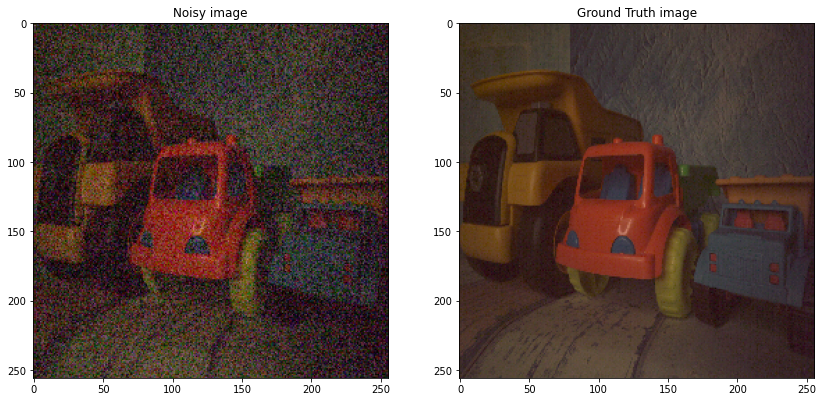

In [25]:
f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(noisy_train_images[4])
axarr[0].set_title("Noisy image")
axarr[1].imshow(gt_train_images[4])
axarr[1].title.set_text("Ground Truth image")

**Image Augmentation**

Using Tensorflow : https://www.tensorflow.org/api_docs/python/tf/image

In [26]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE = 4
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

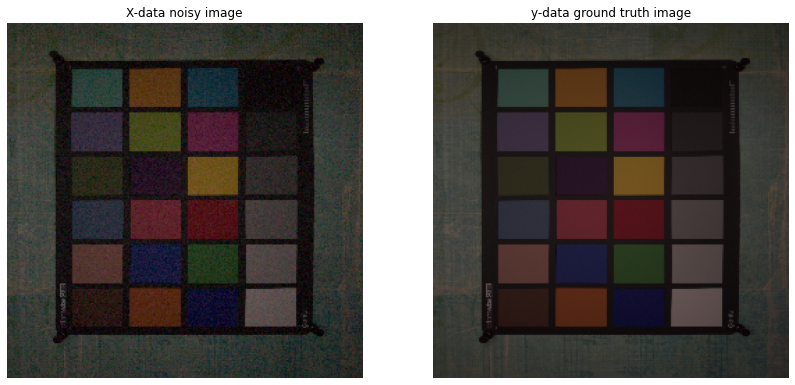

In [32]:
#CHECK of the Data generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

# **Denoise using Autoencoder**
A Denoising Autoencoder is a modification on the autoencoder to prevent the network learning the identity function. Specifically, if the autoencoder is too big, then it can just learn the data, so the output equals the input, and does not perform any useful representation learning or dimensionality reduction. Denoising autoencoders solve this problem by corrupting the input data on purpose, adding noise or masking some of the input values.

In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, Add
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [34]:
def create_model():
    tf.keras.backend.clear_session()

    input_0 = Input(shape=(256,256,3), name="input_layer")
    conv_layer_1 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_1")(input_0)
    conv_layer_2 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_2")(conv_layer_1)
    conv_layer_3 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_3")(conv_layer_2)
    conv_layer_4 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_4")(conv_layer_3)
    conv_layer_5 = Conv2D(filters=128, kernel_size=3, padding='same', name="conv_5")(conv_layer_4)

    deconv_layer_5 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_5")(conv_layer_5)
    deconv_layer_5 = Add(name="add_1")([conv_layer_4, deconv_layer_5])
    deconv_layer_4 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_4")(deconv_layer_5)
    deconv_layer_3 = Conv2DTranspose(filters=256, kernel_size=3, padding='same', name="deconv_3")(deconv_layer_4)
    deconv_layer_3 = Add(name="add_2")([conv_layer_2, deconv_layer_3])
    deconv_layer_2 = Conv2DTranspose(filters=128, kernel_size=3, padding='same', name="deconv_2")(deconv_layer_3)
    deconv_layer_1 = Conv2DTranspose(filters=3, kernel_size=3, padding='same', name="deconv_1")(deconv_layer_2)
    out = Add(name="add_3")([input_0, deconv_layer_1])

    model = Model(inputs=[input_0], outputs=[out])
    return model

In [35]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 256, 256, 256 3328        input_layer[0][0]                
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 256, 256, 256 262400      conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 256, 256, 256 590080      conv_2[0][0]                     
______________________________________________________________________________________________

In [37]:
# Lets Compile the Model
steps_per_epoch_train = 200
steps_per_epoch_validation = 200
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0001))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=200,
                        verbose=1,
                        callbacks=callbacks_lst)

NameError: ignored